##### Importing Libraries

In [34]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pickle

##### Importing Data

In [35]:
df_true = pd.read_csv("./data/NEWS/True.csv")
df_fake = pd.read_csv("./data/NEWS/Fake.csv")
print(str(df_true.shape[0])+" entries for true facts")
print(str(df_fake.shape[0])+" entries for fake facts")

21417 entries for true facts
23481 entries for fake facts


In [36]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [37]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [38]:
df_true["label"] = "1"
df_fake["label"] = "0"
df = pd.concat([df_fake, df_true])
df = df.sample(frac=1).reset_index(drop=True)

print("Combined dataframe has ", df.shape[0], " entries")
df.head()

Combined dataframe has  44898  entries


,title,text,subject,date,label
0,Nobel laureate says Trump policies may lead to...,STOCKHOLM (Reuters) - U.S. President-elect Don...,politicsNews,"December 7, 2016",1
1,Senate Republican leader says still aiming for...,WASHINGTON (Reuters) - The top Republican in t...,politicsNews,"April 25, 2017",1
2,"OBAMA’S PLAN EXPOSED: 115,000 IMMIGRANTS In Te...",The fundamental transformation of America: Wat...,politics,"Sep 21, 2015",0
3,"BOILER ROOM – EP #58 – Lord of the Pedo Rings,...",Tune in to the Alternate Current Radio Network...,Middle-east,"May 26, 2016",0
4,Venezuela opposition leader Guevara seeks refu...,CARACAS (Reuters) - Prominent Venezuelan lawma...,worldnews,"November 5, 2017",1


##### Refactoring columns

In [39]:
df.text = df.title+df.text
df.drop(columns=["title", "subject", "date"], axis = 1, inplace=True)
df.head()

,text,label
0,Nobel laureate says Trump policies may lead to...,1
1,Senate Republican leader says still aiming for...,1
2,"OBAMA’S PLAN EXPOSED: 115,000 IMMIGRANTS In Te...",0
3,"BOILER ROOM – EP #58 – Lord of the Pedo Rings,...",0
4,Venezuela opposition leader Guevara seeks refu...,1


##### Checking for Missing values

In [40]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [41]:
X = df["text"]
Y = df["label"]
print(X.shape[0])
print(Y.shape[0])

44898
44898


In [42]:
stop_words = set(stopwords.words('english')) 
def preprocesFactDescription(sentence):
    lemma_words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(sentence) 
    for word in word_tokens: 
        if word not in stop_words: 
            new_word = re.sub('[^a-zA-Z]', '',word)
            new_word = new_word.lower()
            new_word = wordnet_lemmatizer.lemmatize(new_word)
            lemma_words.append(new_word)
    return " ".join(lemma_words)

In [43]:
## Download punkt and wordnet

In [44]:
X = [preprocesFactDescription(i) for i in X]

In [45]:
X = pd.DataFrame(X)
y = pd.DataFrame(Y)
X.shape, y.shape

((44898, 1), (44898, 1))

###### Train-Test Split 

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((35918, 1), (8980, 1), (35918, 1), (8980, 1))

##### Converting text to vectors using Tfidf vectorizer
###### Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents)
######  Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t))

In [47]:
# create the transform
vectorizer = TfidfVectorizer()

# transforming
tfidf_train = vectorizer.fit_transform(x_train.iloc[:,0])
tfidf_test = vectorizer.transform(x_test.iloc[:,0])

In [48]:
tfidf_train.shape, tfidf_test.shape

((35918, 187138), (8980, 187138))

##### Building Model with PassiveAgressiveClassifier

In [49]:
pac = PassiveAggressiveClassifier(random_state = 7,loss = 'squared_hinge',  max_iter = 50, C = 0.16)
pac.fit(tfidf_train, y_train.values.ravel())

y_pred_train = pac.predict(tfidf_train)
score_train = accuracy_score(y_train, y_pred_train)

#Predict on the test set and calculate accuracy
y_pred_test = pac.predict(tfidf_test)
score_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy Train enteries: {round(score_train*100, 2)}%')
print(f'Accuracy Test enteries: {round(score_test*100, 2)}%')

Accuracy Train enteries: 100.0%
Accuracy Test enteries: 99.62%


##### Visualizing results using Confusion Matrix

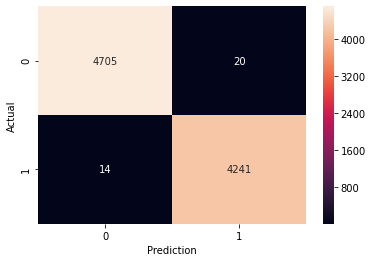

In [50]:
ax = sns.heatmap(confusion_matrix(y_test,y_pred_test), annot=True, fmt="d")
ax.set(xlabel='Prediction', ylabel='Actual')
plt.show()

##### Testing the Model with random fact

In [51]:
def output_lable(n):
    if n == '1':
        return "\nTrue News"
    if n == '0':
        return "\nFalse News"
    
def testing(news, model):
    lnews = preprocesFactDescription(news)

    df = pd.DataFrame([lnews])

    x = df.iloc[:,0]
    x = vectorizer.transform(x)

    x_pred = model.predict(x)

    return output_lable(x_pred)

In [52]:
fact = str(input())
print(testing(fact, pac))


True News


In [53]:
model_save_file = "passive_aggressive_model.pkl"
with open(model_save_file, "wb") as file:
    pickle.dump(pac, file)

In [54]:
model_save_file = "passive_aggressive_model.pkl"
with open(model_save_file, "rb") as file:
    pac_model = pickle.load(file)

In [55]:
print(testing("Russia says closely monitoring signals from Trump's team: RIA", pac_model))


False News
